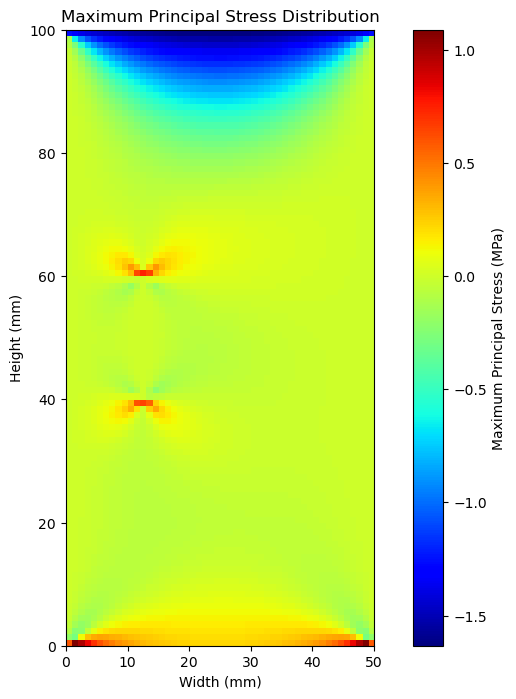

In [4]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
from numba import jit
import matplotlib.pyplot as plt
#导入

@jit(nopython=True)
def compute_element_matrix(node_coords, E_e, nu, thickness):
    """计算单元刚度矩阵"""
    D = E_e/(1 - nu**2) * np.array([[1, nu, 0],
                                   [nu, 1, 0],
                                   [0, 0, (1-nu)/2]])
    
    # 高斯积分点
    gauss_points = np.array([(-0.57735026919, -0.57735026919),
                            (0.57735026919, -0.57735026919),
                            (0.57735026919, 0.57735026919),
                            (-0.57735026919, 0.57735026919)])
    weights = np.array([1.0, 1.0, 1.0, 1.0])
    
    Ke = np.zeros((8, 8))
    for i in range(4):
        xi, eta = gauss_points[i]
        w = weights[i]
        
        dN_dxi = 0.25 * np.array([
            [eta-1, 1-eta, 1+eta, -eta-1],
            [xi-1, -xi-1, xi+1, 1-xi]
        ])
        
        J = dN_dxi @ node_coords
        detJ = J[0,0]*J[1,1] - J[0,1]*J[1,0]
        
        # 计算J的逆矩阵
        invJ = np.array([[J[1,1], -J[0,1]], [-J[1,0], J[0,0]]]) / detJ
        dN_dx = invJ @ dN_dxi
        
        B = np.zeros((3, 8))
        for j in range(4):
            B[0, 2*j] = dN_dx[0, j]
            B[1, 2*j+1] = dN_dx[1, j]
            B[2, 2*j] = dN_dx[1, j]
            B[2, 2*j+1] = dN_dx[0, j]
        
        Ke += (B.T @ D @ B) * detJ * w * thickness
    
    return Ke

def main():
    # 参数设置
    nx, ny = 50, 100
    width, height = 50.0, 100.0
    E = 210e3
    nu = 0.3
    thickness = 1.0
    applied_stress = -6.0
    crack_x = (12, 13)
    crack_y = (40, 60)

    # 生成网格
    x = np.linspace(0, width, nx + 1)
    y = np.linspace(0, height, ny + 1)
    X, Y = np.meshgrid(x, y)
    nodes = np.column_stack((X.flatten(), Y.flatten()))

    # 生成单元连接性（向量化操作）
    i = np.arange(nx*ny)
    row = i // nx
    col = i % nx
    n0 = row*(nx+1) + col
    elements = np.column_stack((n0, n0+1, n0+nx+2, n0+nx+1))

    # 标记裂纹区域（向量化操作）
    element_centers = np.mean(nodes[elements], axis=1)
    crack_mask = ((crack_x[0] <= element_centers[:,0]) & 
                 (element_centers[:,0] <= crack_x[1]) & 
                 (crack_y[0] <= element_centers[:,1]) & 
                 (element_centers[:,1] <= crack_y[1]))
    E_values = np.where(crack_mask, 1e-6, E)

    # 组装刚度矩阵
    dof = 2 * len(nodes)
    K = lil_matrix((dof, dof))

    # 并行计算单元刚度矩阵
    for elem_idx, elem in enumerate(elements):
        node_coords = nodes[elem]
        Ke = compute_element_matrix(node_coords, E_values[elem_idx], nu, thickness)
        
        # 组装到全局矩阵
        dofs = np.array([[2*n, 2*n+1] for n in elem]).flatten()
        for i in range(8):
            for j in range(8):
                K[dofs[i], dofs[j]] += Ke[i,j]

    # K = csr_matrix(K)

    # # 边界条件（向量化操作）
    # bottom_nodes = np.where(nodes[:,1] == 0.0)[0]
    # fixed_dofs = np.concatenate([2*bottom_nodes, 2*bottom_nodes+1])

    # # 载荷向量
    # F = np.zeros(dof)
    # top_nodes = np.where(nodes[:,1] == height)[0]
    # force_per_node = applied_stress * width * thickness / len(top_nodes)
    # F[2*top_nodes + 1] = force_per_node

    # # 处理边界条件
    # for fd in fixed_dofs:
    #     F[fd] = 0.0
    #     K[fd, :] = 0
    #     K[:, fd] = 0
    #     K[fd, fd] = 1.0

    # # 求解
    # U = spsolve(K, F)
    # 边界条件（向量化操作）
    bottom_nodes = np.where(nodes[:,1] == 0.0)[0]
    fixed_dofs = np.concatenate([2*bottom_nodes, 2*bottom_nodes+1])

    # 载荷向量
    F = np.zeros(dof)
    top_nodes = np.where(nodes[:,1] == height)[0]
    force_per_node = applied_stress * width * thickness / len(top_nodes)
    F[2*top_nodes + 1] = force_per_node

    # 处理边界条件
    for fd in fixed_dofs:
        F[fd] = 0.0
        K[fd, :] = 0
        K[:, fd] = 0
        K[fd, fd] = 1.0

    # 转换为CSR格式并求解
    K = csr_matrix(K)
    U = spsolve(K, F)

    # 计算应力（向量化操作）
    stress_matrix = np.zeros((ny, nx))
    for idx, elem in enumerate(elements):
        node_coords = nodes[elem]
        u = np.concatenate([U[2*elem[i]:2*elem[i]+2] for i in range(4)])
        
        # 计算中心点应力
        xi, eta = 0.0, 0.0
        dN_dxi = 0.25 * np.array([
            [eta-1, 1-eta, 1+eta, -eta-1],
            [xi-1, -xi-1, xi+1, 1-xi]
        ])
        J = dN_dxi @ node_coords
        dN_dx = np.linalg.inv(J) @ dN_dxi
        
        B = np.zeros((3, 8))
        for i in range(4):
            B[0, 2*i] = dN_dx[0, i]
            B[1, 2*i+1] = dN_dx[1, i]
            B[2, 2*i] = dN_dx[1, i]
            B[2, 2*i+1] = dN_dx[0, i]
        
        strain = B @ u
        E_e = E_values[idx]
        D = E_e/(1 - nu**2) * np.array([[1, nu, 0],
                                       [nu, 1, 0],
                                       [0, 0, (1-nu)/2]])
        stress = D @ strain
        
        s_x, s_y, t_xy = stress
        avg = (s_x + s_y)/2
        radius = np.sqrt(((s_x - s_y)/2)**2 + t_xy**2)
        sigma1 = avg + radius
        stress_matrix[idx//nx, idx%nx] = sigma1

    # 绘图
    plt.figure(figsize=(10, 8))
    plt.imshow(stress_matrix, cmap='jet', extent=[0, width, 0, height])
    plt.colorbar(label='Maximum Principal Stress (MPa)')
    plt.xlabel('Width (mm)')
    plt.ylabel('Height (mm)')
    plt.title('Maximum Principal Stress Distribution')
    plt.show()

if __name__ == "__main__":
    main()

In [4]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# Parameters
nx, ny = 50, 100
width, height = 50.0, 100.0
E = 210e3
nu = 0.3
thickness = 1.0
applied_stress = -6.0
crack_x = (20, 30)
crack_y = (40, 60)

# --- Mesh Generation ---
num_nodes_x = nx + 1
num_nodes_y = ny + 1
x_coords = np.linspace(0, width, num_nodes_x)
y_coords = np.linspace(0, height, num_nodes_y)
nodes = np.array(np.meshgrid(x_coords, y_coords)).T.reshape(-1, 2)

elements = np.array([
    [j * num_nodes_x + i, j * num_nodes_x + i + 1, (j + 1) * num_nodes_x + i + 1, (j + 1) * num_nodes_x + i]
    for j in range(ny) for i in range(nx)
])

# --- Crack Modeling ---
element_centers = np.mean(nodes[elements], axis=1)
crack_mask = (
    (element_centers[:, 0] >= crack_x[0]) & (element_centers[:, 0] <= crack_x[1]) &
    (element_centers[:, 1] >= crack_y[0]) & (element_centers[:, 1] <= crack_y[1])
)
E_values = np.where(crack_mask, 1e-6, E)

# --- Gauss Points and Weights ---
gauss_points = np.array([
    (-1/np.sqrt(3), -1/np.sqrt(3)),
    (1/np.sqrt(3), -1/np.sqrt(3)),
    (1/np.sqrt(3), 1/np.sqrt(3)),
    (-1/np.sqrt(3), 1/np.sqrt(3))
])
weights = np.ones(4)

# --- Material Matrix ---
def material_matrix(E_e, nu):
    return E_e / (1 - nu**2) * np.array([[1, nu, 0],
                                         [nu, 1, 0],
                                         [0, 0, (1 - nu) / 2]])

# --- Shape Function Derivatives (PRE-COMPUTED) ---
dN_dxi = 0.25 * np.array([
    [-(1 - gp[1]), (1 - gp[1]), (1 + gp[1]), -(1 + gp[1])] for gp in gauss_points
])
dN_deta = 0.25 * np.array([
    [-(1 - gp[0]), -(1 + gp[0]), (1 + gp[0]), (1 - gp[0])] for gp in gauss_points
])

def compute_Ke(node_coords, E_e, nu, thickness):
    """Computes the element stiffness matrix."""
    Ke = np.zeros((8, 8))
    D = material_matrix(E_e, nu)

    for gp_idx in range(len(gauss_points)):
        dNdxi = dN_dxi[gp_idx]
        dNdeta = dN_deta[gp_idx]

        J = np.array([
            [np.dot(dNdxi, node_coords[:, 0]), np.dot(dNdxi, node_coords[:, 1])],
            [np.dot(dNdeta, node_coords[:, 0]), np.dot(dNdeta, node_coords[:, 1])]
        ])

        detJ = np.linalg.det(J)
        invJ = np.linalg.inv(J)

        dNdx = np.zeros((2, 4))
        dNdx[0, :] = invJ[0, 0] * dNdxi + invJ[0, 1] * dNdeta
        dNdx[1, :] = invJ[1, 0] * dNdxi + invJ[1, 1] * dNdeta

        B = np.zeros((3, 8))
        for i in range(4):
            B[0, 2*i] = dNdx[0, i]
            B[1, 2*i+1] = dNdx[1, i]
            B[2, 2*i] = dNdx[1, i]
            B[2, 2*i+1] = dNdx[0, i]

        Ke += (B.T @ D @ B) * detJ * weights[gp_idx] * thickness
    return Ke

def compute_stress(u, node_coords, E_e, nu):
    """Computes the stress at the center of an element."""

    # Pre-calculated derivatives at the center (xi=0, eta=0)
    dNdxi_c = np.array([-0.25, 0.25, 0.25, -0.25])
    dNdeta_c = np.array([-0.25, -0.25, 0.25, 0.25])

    J_c = np.array([
        [np.dot(dNdxi_c, node_coords[:, 0]), np.dot(dNdxi_c, node_coords[:, 1])],
        [np.dot(dNdeta_c, node_coords[:, 0]), np.dot(dNdeta_c, node_coords[:, 1])]
    ])
    invJ_c = np.linalg.inv(J_c)

    dNdx_c = np.zeros((2, 4))
    dNdx_c[0, :] = invJ_c[0, 0] * dNdxi_c + invJ_c[0, 1] * dNdeta_c
    dNdx_c[1, :] = invJ_c[1, 0] * dNdxi_c + invJ_c[1, 1] * dNdeta_c


    B_c = np.zeros((3, 8))
    for i in range(4):
        B_c[0, 2*i] = dNdx_c[0, i]
        B_c[1, 2*i+1] = dNdx_c[1, i]
        B_c[2, 2*i] = dNdx_c[1, i]
        B_c[2, 2*i+1] = dNdx_c[0, i]

    strain = B_c @ u
    D = material_matrix(E_e, nu)  # Use function for consistency
    stress = D @ strain

    s_x, s_y, t_xy = stress
    sigma1 = (s_x + s_y) / 2 + np.sqrt(((s_x - s_y) / 2)**2 + t_xy**2)
    return sigma1

# --- Stiffness Matrix Assembly ---
dof = 2 * len(nodes)
K = lil_matrix((dof, dof))

for elem_idx, elem in enumerate(elements):
    node_coords = nodes[elem]
    Ke = compute_Ke(node_coords, E_values[elem_idx], nu, thickness)

    idx = np.repeat(elem, 2) * 2
    idx = idx.reshape(-1, 2) + np.array([0, 1])
    rows = np.repeat(idx, 8, axis=0)
    cols = np.tile(idx, (8, 1))
    K[rows.flatten()[:, None], cols.flatten()[None, :]] += Ke

K = csr_matrix(K)

# --- Boundary Conditions ---
bottom_nodes = np.where(nodes[:, 1] == 0.0)[0]
fixed_dofs = np.concatenate([2 * bottom_nodes, 2 * bottom_nodes + 1])

# --- Load Vector ---
F = np.zeros(dof)
top_edge_elements = elements[np.isclose(nodes[elements[:, 3], 1], height)]
top_nodes = np.unique(top_edge_elements[:, 2:])
top_node_coords = nodes[top_nodes]
edge_lengths = np.diff(top_node_coords[:, 0])
edge_lengths = np.concatenate(([edge_lengths[0]], edge_lengths))
nodal_forces = applied_stress * edge_lengths * thickness / 2
F[2 * top_nodes + 1] = nodal_forces

# --- Apply Boundary Conditions ---
K = K.tolil()
K[fixed_dofs, :] = 0
K[:, fixed_dofs] = 0
K[fixed_dofs, fixed_dofs] = 1.0
F[fixed_dofs] = 0.0
K = K.tocsr()

# --- Solve ---
U = spsolve(K, F)

# --- Stress Calculation ---
stress_matrix = np.zeros((ny, nx))

for elem_idx, elem in enumerate(elements):
    u = U[np.repeat(elem * 2, 2) + np.tile([0, 1], 4)]
    node_coords = nodes[elem]
    sigma1 = compute_stress(u, node_coords, E_values[elem_idx], nu) # Use the new function
    stress_matrix[elem_idx // nx, elem_idx % nx] = sigma1



# --- Output and Plotting ---
print("Stress Matrix Dimensions:", stress_matrix.shape)
print(stress_matrix)

plt.imshow(stress_matrix, cmap='jet', origin='lower', extent=[0, width, 0, height])
plt.colorbar(label='Max Principal Stress (MPa)')
plt.title('Stress Distribution')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
#plt.show() # 注释掉show()，以便程序继续执行，如果你想看到图像，请取消注释

LinAlgError: Singular matrix